LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 10/50, Loss: 0.02143164351582527
Epoch 20/50, Loss: 0.011008599773049355
Epoch 30/50, Loss: 0.00695396400988102
Epoch 40/50, Loss: 0.005173258017748594
Epoch 50/50, Loss: 0.004491513129323721
Root Mean Squared Error (RMSE): 0.8708032713877252


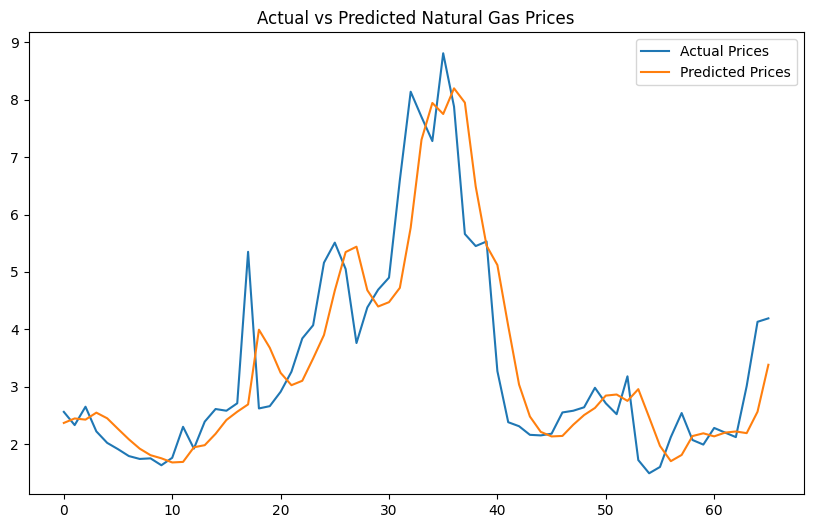

In [ ]:
import pandas as pd

url = '/home/student/Documents/220962344/DeepLearningLab/Week9/data/flat-ui__data.csv'  
data = pd.read_csv(url)

data.head()
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert 'Date' column to datetime and set as index
# data['Month'] = pd.to_datetime(data['Month'])
# data.set_index('Month', inplace=True)

# Ensure there are no missing values
data = data.dropna(subset=['Price'])

# Extract prices and reshape for scaling
prices = data['Price'].values.reshape(-1, 1)

# Normalize the prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)
# Define sequence length (10 days)
sequence_length = 10

# Function to create sequences from the data
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 0])  # Last 10 days
        y.append(data[i + sequence_length, 0])  # 11th day
    return np.array(X), np.array(y)

# Create dataset for LSTM
X, y = create_dataset(scaled_prices, sequence_length)

# Reshape X to be compatible with LSTM input: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
import torch
import torch.nn as nn

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        # Define the fully connected layer to produce output
        self.fc = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Get the output from the last time step
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions

# Instantiate the model
model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1)

# Print the model architecture
print(model)
# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero out previous gradients
    
    # Forward pass
    y_pred = model(X_train_tensor)
    
    # Compute the loss
    loss = loss_fn(y_pred, y_train_tensor.view(-1, 1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    y_test_pred = model(X_test_tensor)

# Invert the scaling to get the actual predicted prices
y_test_pred = scaler.inverse_transform(y_test_pred.numpy())
y_test_actual = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

# Calculate RMSE (Root Mean Squared Error) for evaluation
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_test_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(y_test_pred, label='Predicted Prices')
plt.legend()
plt.title('Actual vs Predicted Natural Gas Prices')
plt.show()


In [11]:
import torch
import torch.nn as nn
import numpy as np
import os
import zipfile
import requests
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader

# Step 1: Download and Unzip the Data
data_url = "https://download.pytorch.org/tutorial/data.zip"
data_path = "data.zip"
if not os.path.exists(data_path):
    # Download the file
    r = requests.get(data_url)
    with open(data_path, 'wb') as f:
        f.write(r.content)
    
    # Unzip the file
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall('data')

# Step 2: Read and preprocess the data
language_data = defaultdict(list)

# Read the data from the files in the 'data/names' folder
data_dir = 'data/data/names'
for filename in os.listdir(data_dir):
    if filename.endswith(".txt"):
        language = filename.split('.')[0]
        with open(os.path.join(data_dir, filename), 'r') as f:
            names = f.read().splitlines()
            language_data[language] = names

# Create character-to-index mapping and language-to-index mapping
all_chars = sorted(set(''.join([name for names in language_data.values() for name in names])))
char2int = {ch: i+1 for i, ch in enumerate(all_chars)}  # Start from 1 (0 is reserved for padding)
char2int['<PAD>'] = 0  # Padding token
int2char = {i: ch for ch, i in char2int.items()}

languages = list(language_data.keys())
language2int = {language: i for i, language in enumerate(languages)}

# Prepare dataset (input: name sequence, target: language)
class NameDataset(Dataset):
    def __init__(self, language_data, char2int, language2int, seq_length=15):
        self.data = []
        self.seq_length = seq_length
        self.char2int = char2int
        self.language2int = language2int
        
        for language, names in language_data.items():
            for name in names:
                # Process the name
                name_indices = [char2int.get(ch, char2int['<PAD>']) for ch in name.lower()]
                name_indices = name_indices[:seq_length]  # truncate to seq_length
                name_indices += [char2int['<PAD>']] * (seq_length - len(name_indices))  # pad to seq_length
                
                language_label = language2int[language]
                self.data.append((name_indices, language_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name, language = self.data[idx]
        return torch.tensor(name, dtype=torch.long), torch.tensor(language, dtype=torch.long)

# Step 3: Create DataLoader
dataset = NameDataset(language_data, char2int, language2int)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Step 4: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Get the last time step
        return out

# Hyperparameters
vocab_size = len(char2int)
embedding_dim = 10
hidden_dim = 64
num_classes = len(language2int)
num_epochs = 20
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Step 5: Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for names, languages in dataloader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(names)
        
        # Compute loss
        loss = criterion(outputs, languages)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == languages).sum().item()
        total_preds += languages.size(0)
    
    accuracy = correct_preds / total_preds * 100
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, Accuracy: {accuracy:.2f}%')

# Step 6: Prediction Function
def predict_language(model, name, char2int, int2language, seq_length=15):
    model.eval()
    with torch.no_grad():
        # Prepare the input
        name = [char2int.get(ch, char2int['<PAD>']) for ch in name.lower()]
        name = name[:seq_length] + [char2int['<PAD>']] * (seq_length - len(name))
        name_tensor = torch.tensor(name).unsqueeze(0)  # Add batch dimension
        
        # Predict the language
        output = model(name_tensor)
        _, predicted_language = torch.max(output, 1)
        
        return int2language[predicted_language.item()]

# Example prediction
test_name = "Darcy"
predicted_language = predict_language(model, test_name, char2int, {i: l for i, l in enumerate(languages)})
print(f'The name "{test_name}" is most likely from the language: {predicted_language}')


Epoch [1/20], Loss: 1.9015, Accuracy: 45.68%
Epoch [2/20], Loss: 1.4483, Accuracy: 57.33%
Epoch [3/20], Loss: 1.2509, Accuracy: 64.16%
Epoch [4/20], Loss: 1.1079, Accuracy: 68.47%
Epoch [5/20], Loss: 0.9860, Accuracy: 71.83%
Epoch [6/20], Loss: 0.9146, Accuracy: 73.34%
Epoch [7/20], Loss: 0.8522, Accuracy: 75.07%
Epoch [8/20], Loss: 0.8073, Accuracy: 76.14%
Epoch [9/20], Loss: 0.7729, Accuracy: 77.15%
Epoch [10/20], Loss: 0.7387, Accuracy: 77.93%
Epoch [11/20], Loss: 0.7148, Accuracy: 78.55%
Epoch [12/20], Loss: 0.6927, Accuracy: 79.09%
Epoch [13/20], Loss: 0.6696, Accuracy: 79.97%
Epoch [14/20], Loss: 0.6510, Accuracy: 80.31%
Epoch [15/20], Loss: 0.6329, Accuracy: 80.69%
Epoch [16/20], Loss: 0.6198, Accuracy: 81.10%
Epoch [17/20], Loss: 0.6004, Accuracy: 81.55%
Epoch [18/20], Loss: 0.5835, Accuracy: 82.03%
Epoch [19/20], Loss: 0.5709, Accuracy: 82.26%
Epoch [20/20], Loss: 0.5648, Accuracy: 82.43%
The name "Darcy" is most likely from the language: 7


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random

text = "hello world, this is a simple character prediction model."
chars = sorted(list(set(text)))  
int2char = {i: ch for i, ch in enumerate(chars)}  
char2int = {ch: i for i, ch in enumerate(chars)}  

seq_length = 5
X = []
y = []

for i in range(len(text) - seq_length):
    X.append([char2int[ch] for ch in text[i:i + seq_length]])
    y.append(char2int[text[i + seq_length]])

X = np.array(X)
y = np.array(y)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  
        return out

vocab_size = len(chars)
embedding_dim = 10
hidden_dim = 50
num_epochs = 100
learning_rate = 0.01

model = LSTMModel(vocab_size, embedding_dim, hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def predict_next_char(model, input_seq):
    model.eval()
    with torch.no_grad():
        input_seq = [char2int[ch] for ch in input_seq]
        input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0)  
        
        output = model(input_seq)
        
        _, predicted_idx = torch.max(output, 1)
        
        predicted_char = int2char[predicted_idx.item()]
        return predicted_char

input_seq = "simpl"  
predicted_char = predict_next_char(model, input_seq)
print(f'Next character after "{input_seq}": {predicted_char}')


Epoch [10/100], Loss: 2.3022
Epoch [20/100], Loss: 0.9053
Epoch [30/100], Loss: 0.1272
Epoch [40/100], Loss: 0.0190
Epoch [50/100], Loss: 0.0065
Epoch [60/100], Loss: 0.0036
Epoch [70/100], Loss: 0.0026
Epoch [80/100], Loss: 0.0021
Epoch [90/100], Loss: 0.0019
Epoch [100/100], Loss: 0.0017
Next character after "simpl": e
